In [1]:
import pandas as pd
import numpy as np
import plotly
import plotly.graph_objs as go
import os

plotly.offline.init_notebook_mode(connected=True)

In [2]:
def ranking_df_creator(ranking_file_path):
    ranking_files_list = os.listdir(ranking_file_path)
    ranking_df = pd.DataFrame()
    col_names = ['date', 
               'year',
               'month',
               'day',
               'rank_text',
               'rank_number',
               'movement',
               'direction',
               'age',
               'points',
               'tournaments_played',
               'player_profile',
               'player_name',
               'player_id']
    
    for i in range(len(ranking_files_list)):
        tmp_df = pd.read_csv(str(ranking_file_path + ranking_files_list[i]), header = None, names = col_names)
        ranking_df = pd.concat([ranking_df, tmp_df])
    
    ranking_df['date'] = ranking_df['date'].replace('\.','/', regex=True)
    ranking_df['date'] = pd.to_datetime(ranking_df['date'])
    ranking_df = ranking_df.sort_values(by = 'date')
    ranking_df = ranking_df.reset_index(drop = True)
    
    return ranking_df

In [3]:
#points = pd.read_csv('charting-m-points-utf8.csv')
rankings = ranking_df_creator('rankings/')

In [3]:
points['player1'] = points['match_id'].str.split('-', expand=True)[4]
points['player2'] = points['match_id'].str.split('-', expand=True)[5]

In [4]:
points['winner'] = np.where(points['PtWinner'] == 1.0, points['player1'], points['player2'])

In [5]:
num_fe = points[points['isForced']==True].groupby('winner').count()['match_id'].sort_values(ascending=False)

In [6]:
num_win = points.groupby('winner').count()['match_id'].sort_values(ascending=False)

In [7]:
percent_fe = num_fe/num_win

In [181]:
fe_rate_df = pd.concat([num_fe, num_win, percent_fe], axis=1, sort=True).reset_index()
fe_rate_df.columns = ['player', 'num_forced_err', 'total_winners', 'percent_forced_err']
total_points = points.groupby('player1').count()['match_id'].add(points.groupby('player2').count()['match_id'], fill_value=0).reset_index()
total_points.columns = ['player', 'total_points']
fe_rate_df = fe_rate_df.merge(total_points, on='player')

In [194]:
fe_rate_filtered = fe_rate_df[fe_rate_df['total_points'] > 750].sort_values(by='percent_forced_err', ascending=False)

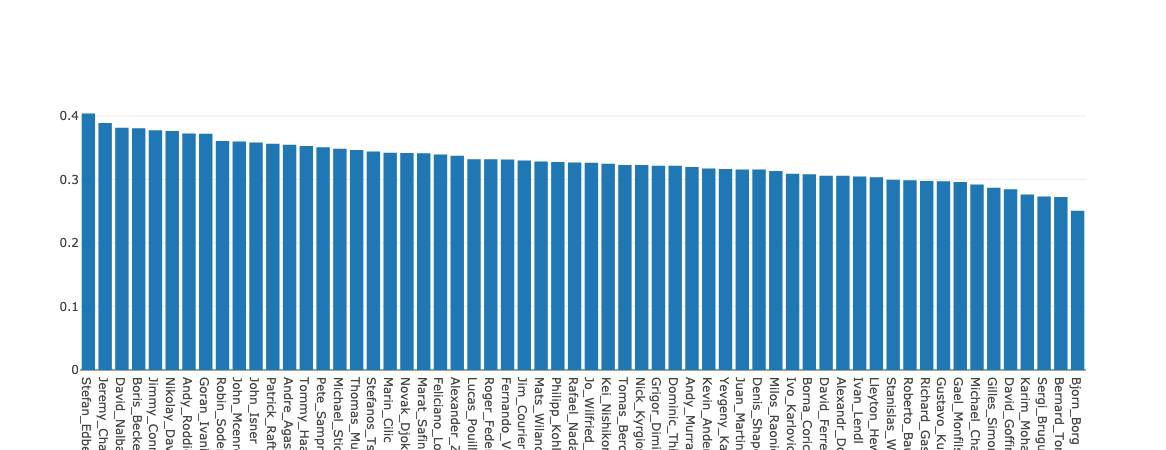

In [13]:
data = [go.Bar(x=fe_rate_filtered['player'], y=fe_rate_filtered['percent_forced_err'])]
plotly.offline.iplot(data)

In [138]:
rankings['name_fixed'] = rankings['player_name'].str.replace('%20', '-')

In [139]:
highest_ranks = rankings[['name_fixed','rank_number']].groupby(['name_fixed']).min().reset_index()

In [140]:
highest_ranks['player'] = highest_ranks['name_fixed'].str.split('-').apply(lambda x: [i.capitalize() for i in x]).apply(lambda x: '_'.join(x))

In [195]:
fe_rate_ranks = fe_rate_filtered.merge(highest_ranks[['player', 'rank_number']], on='player')

In [214]:
fe_rate_ranks['adj_ranks'] = fe_rate_ranks['rank_number'].apply(lambda x: 'Top 4' if x <= 4 else ('Top 10' if x <= 10 else ('Top 50' if x <= 50 else ('Top 100' if x <= 100 else '100+'))))

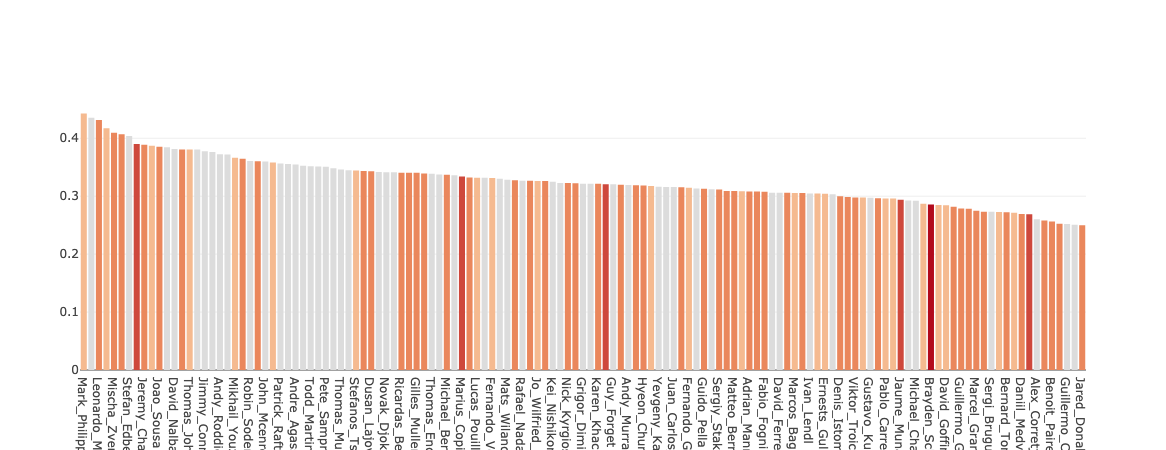

In [203]:
data = [go.Bar(
    x=fe_rate_ranks['player'], 
    y=fe_rate_ranks['percent_forced_err'], 
    marker=dict(
        color=fe_rate_ranks['adj_ranks']), 
    text=fe_rate_ranks['rank_number'], 
    textposition='auto')]
plotly.offline.iplot(data)

In [204]:
fe_rate_ranks.groupby('player')

In [219]:
for label, subset in fe_rate_ranks.groupby('adj_ranks'):
    print(subset.player)

112    Brayden_Schnur
Name: player, dtype: object
0       Mark_Philippoussis
3               Jiri_Novak
9           Radek_Stepanek
14        Thomas_Johansson
20         Mikhail_Youzhny
25              John_Isner
36      Stefanos_Tsitsipas
52           Lucas_Pouille
54       Fernando_Verdasco
60      Jo_Wilfried_Tsonga
75          Kevin_Anderson
80       Fernando_Gonzalez
87          Wayne_Ferreira
94        Marcos_Baghdatis
97             Marc_Rosset
98          Ernests_Gulbis
103        Richard_Gasquet
106    Pablo_Carreno_Busta
107           Gael_Monfils
111           Gilles_Simon
113              Jack_Sock
114           David_Goffin
121          Tommy_Robredo
123        Nicolas_Almagro
Name: player, dtype: object
7      Hubert_Hurkacz
50       Marius_Copil
69       Dustin_Brown
108       Jaume_Munar
125     Reilly_Opelka
Name: player, dtype: object
1                 Tim_Henman
6              Stefan_Edberg
11                  Pat_Cash
12          David_Nalbandian
15              Bori

In [220]:
colors = {
    'Top 4': 'red',
    'Top 10': 'green',
    'Top 50': 'blue',
    'Top 100': 'purple',
    '100+': 'yellow'
}

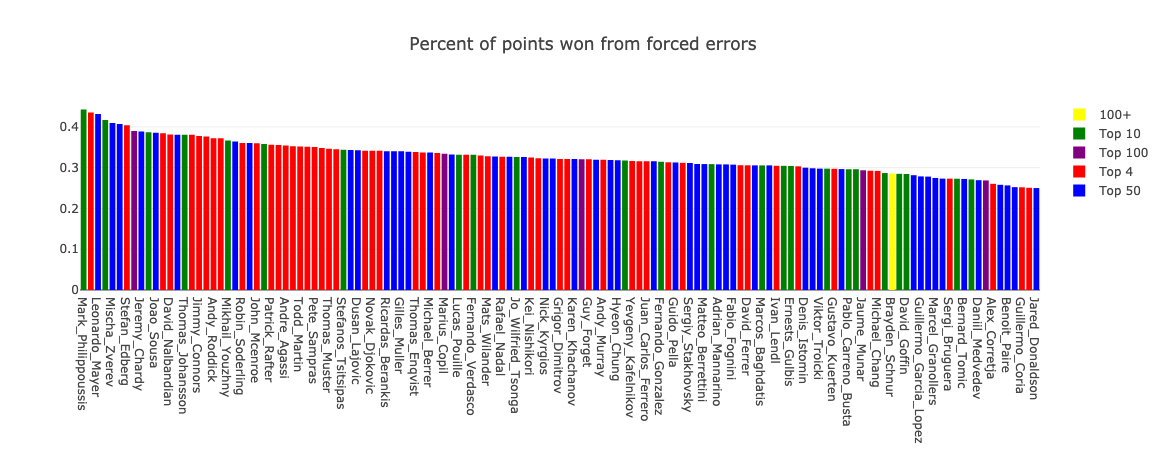

In [238]:
bars = []
for label, subset in fe_rate_ranks.groupby('adj_ranks'):
    bars.append(go.Bar(
        x=subset['player'],
        y=subset['percent_forced_err'],
        marker=dict(
            color=colors[label]
        ),
        name=label
    ))
layout = {
    'xaxis': {
        'categoryorder': 'array',
        'categoryarray': fe_rate_ranks.sort_values('percent_forced_err', ascending=False)['player']
    },
    'margin': {
        'b': 160
    },
    'title': 'Percent of points won from forced errors'
}
fig = go.Figure(data=bars, layout=layout)
plotly.offline.iplot(fig)

In [239]:
fe_rate_ranks

,player,num_forced_err,total_winners,percent_forced_err,total_points,rank_number,adj_ranks
0,Mark_Philippoussis,313,707,0.442716,1418.0,8,Top 10
1,Tim_Henman,331,760,0.435526,1629.0,4,Top 4
2,Leonardo_Mayer,325,753,0.431607,1572.0,21,Top 50
3,Jiri_Novak,219,525,0.417143,1049.0,5,Top 10
4,Mischa_Zverev,149,364,0.409341,823.0,25,Top 50
5,Pablo_Cuevas,173,425,0.407059,835.0,19,Top 50
6,Stefan_Edberg,2864,7092,0.403835,14186.0,1,Top 4
7,Hubert_Hurkacz,227,582,0.390034,1184.0,52,Top 100
8,Jeremy_Chardy,431,1108,0.388989,2313.0,25,Top 50
9,Radek_Stepanek,154,398,0.386935,855.0,8,Top 10
